In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ulmpyzl8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ulmpyzl8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d41864bc701b446a230f5baedda56a264b0bc180bda3aeea7ee08bf6226e9722
  Stored in directory: /tmp/pip-ephem-wheel-cache-vaxhpc_h/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from google.colab import drive
import cv2

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to the folder containing images and masks
images_folder_path = "/content/drive/MyDrive/MRI Images/ab_image_new"
masks_folder_path = "/content/drive/MyDrive/MRI Images/white-masks"

# Desired patch size for smaller images and step size ==> when the image is too big, it divides into smaller "patches" for easier processing
patch_size = 256
step = 256

In [22]:
def patchify(image, patch_shape, step):
    patches = []
    for i in range(0, image.shape[0] - patch_shape[0] + 1, step):
        for j in range(0, image.shape[1] - patch_shape[1] + 1, step):
            patch = image[i:i+patch_shape[0], j:j+patch_shape[1]]
            patches.append(patch)
    return np.array(patches)

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            images.append(resize_image(image,1024,768))
    return images

# The function below is to be used when there is uncertainity in the dimensions of all the images within a folder
def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

def view_resized_images(images, masks=None, max_size=65536):
    """
    View resized images and masks (optional) using matplotlib.
    """
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))

    for i, image in enumerate(images):
        resized_image = resize_image(image, max_size=max_size)
        axes[i, 0].imshow(resized_image)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis('off')

        if masks is not None:
            resized_mask = resize_image(masks[i], max_size=max_size)
            axes[i, 1].imshow(resized_mask, cmap='gray')
            axes[i, 1].set_title(f"Mask {i+1}")
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
images = load_images_from_folder(images_folder_path)
masks = load_images_from_folder(masks_folder_path)

# Resize images to 1024x768 resolution as certain images are 1024x768 but others are 2048x2048
# resized_images = [resize_image(image, 1024, 768) for image in images]
# resized_masks = [resize_image(mask, 1024, 768) for mask in masks]

In [26]:
print(images[0].shape)
print(masks[0].shape)
# print(resized_images[0].shape)

(768, 1024, 3)
(768, 1024, 3)


In [27]:
all_img_patches = []
for image in images:
    patches_img = patchify(image, (patch_size, patch_size), step=step)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_1 = np.array(all_img_patches)

all_mask_patches = []
for mask in masks:
    patches_mask = patchify(mask, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks_1 = np.array(all_mask_patches)

In [28]:
images_1.shape

(384000, 256, 3)

In [29]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images_1[valid_indices]
filtered_masks = masks_1[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (125, 256, 3)
Mask shape: (125, 256, 3)


In [30]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [31]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 125
})

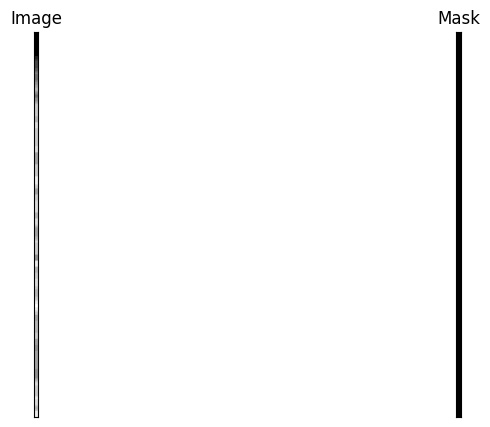

In [32]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()